In [1]:
import pandas as pd
import numpy as np

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

# Load Dataset

In [3]:
data_path = '../features_3_sec.csv'
orig_df = pd.read_csv(data_path)

labels = orig_df['label']

features_df = orig_df.drop(['filename','length','label'], axis=1)
features_df.head()

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,3714.560359,1.080790e+06,...,-2.853603,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767
1,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,3869.682242,6.722448e+05,...,4.074709,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081
2,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,3997.639160,7.907127e+05,...,4.806280,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122
3,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,3568.300218,9.216524e+05,...,-1.359111,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678
4,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,3469.992864,6.102111e+05,...,2.092937,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694


# Feature normalization

In [4]:
features_scaled = StandardScaler().fit_transform(features_df)
scaled_df = pd.DataFrame(features_scaled)

# Turn string labels to classes

In [5]:
label_map = {np.unique(labels)[i]:i for i in range(10)}
labels = labels.map(lambda i: label_map[i])

# Split into train and test

In [6]:
X_train, X_test, y_train, y_test = train_test_split(scaled_df, labels, test_size=0.2)
print(f'Train test size: {X_train.shape[0]} rows, test set size: {X_test.shape[0]} rows')

Train test size: 7992 rows, test set size: 1998 rows


# Fit model

In [7]:
best_acc = -1
best_n_est = None
best_model = None

for n_est in [50,100,200,500]:
    print(f'Trying n_estimators = {n_est}')
    clf = GradientBoostingClassifier(n_estimators=n_est)
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    accuracy = accuracy_score(preds, y_test)
    
    if accuracy>best_acc:
        best_n_est = n_est
        best_acc = accuracy
        best_model = clf
        
    print(f'Best accuracy = {best_acc}')

Trying n_estimators = 50
Best accuracy = 0.7892892892892893
Trying n_estimators = 100
Best accuracy = 0.8313313313313313
Trying n_estimators = 200
Best accuracy = 0.8693693693693694
Trying n_estimators = 500
Best accuracy = 0.8908908908908909


# Make predictions and assess accuracy

In [8]:
preds = clf.predict(X_test)
accuracy = accuracy_score(preds, y_test)
confusion_mat = confusion_matrix(preds, y_test)

In [12]:
confusion_mat

array([[174,   0,   6,   4,   0,   3,   4,   0,   2,   7],
       [  1, 191,   0,   0,   1,   8,   0,   1,   0,   1],
       [  9,   1, 183,   4,   2,   3,   2,   4,   6,  11],
       [  2,   0,   4, 180,   1,   0,   5,   1,   4,   6],
       [  1,   0,   2,   2, 164,   0,   1,   4,   5,   1],
       [  3,   5,   5,   0,   2, 182,   0,   1,   2,   1],
       [  6,   0,   0,   1,   2,   1, 189,   1,   0,   5],
       [  0,   0,   0,   1,   5,   1,   0, 196,   1,   1],
       [  1,   0,   2,   4,   6,   0,   1,   6, 157,   7],
       [  1,   1,   5,   4,   3,   2,   8,   1,   3, 164]])

       label  accuracy
1  classical  0.964646
7        pop  0.911628
5       jazz  0.910000
3      disco  0.900000
6      metal  0.900000
2    country  0.884058
4     hiphop  0.881720
0      blues  0.878788
8     reggae  0.872222
9       rock  0.803922


<BarContainer object of 10 artists>

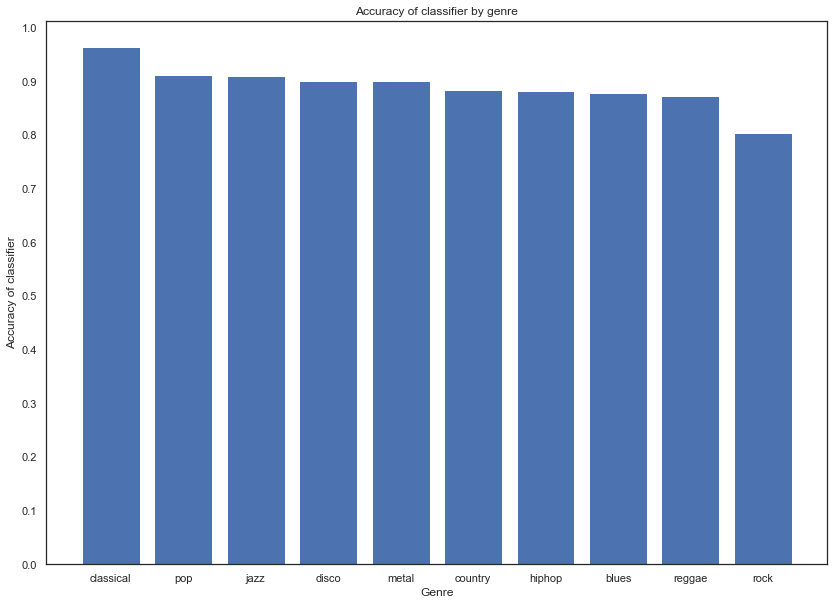

In [48]:
diag_entries = [confusion_mat[i,i] for i in range(len(confusion_mat))]
class_accuracy = diag_entries / np.sum(confusion_mat, axis=0)
label_names = list(label_map.keys())

acc_df = pd.DataFrame({'label':label_names, 'accuracy':class_accuracy})
acc_df = acc_df.sort_values(by='accuracy', ascending=False)
print(acc_df)

plt.xlabel('Genre')
plt.ylabel('Accuracy of classifier')

plt.yticks(np.arange(0,1.05,step=0.1))

plt.title('Accuracy of classifier by genre')
plt.bar(acc_df['label'], acc_df['accuracy'])

In [49]:
confusion_mat

array([[174,   0,   6,   4,   0,   3,   4,   0,   2,   7],
       [  1, 191,   0,   0,   1,   8,   0,   1,   0,   1],
       [  9,   1, 183,   4,   2,   3,   2,   4,   6,  11],
       [  2,   0,   4, 180,   1,   0,   5,   1,   4,   6],
       [  1,   0,   2,   2, 164,   0,   1,   4,   5,   1],
       [  3,   5,   5,   0,   2, 182,   0,   1,   2,   1],
       [  6,   0,   0,   1,   2,   1, 189,   1,   0,   5],
       [  0,   0,   0,   1,   5,   1,   0, 196,   1,   1],
       [  1,   0,   2,   4,   6,   0,   1,   6, 157,   7],
       [  1,   1,   5,   4,   3,   2,   8,   1,   3, 164]])

<BarContainer object of 5 artists>

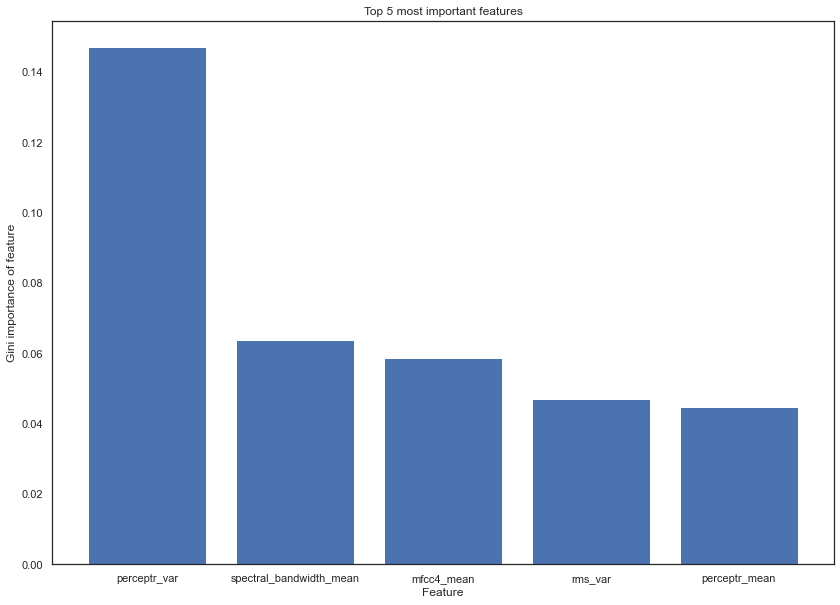

In [44]:
feature_importance = clf.feature_importances_
col_names = features_df.columns

importance_df = pd.DataFrame({'col':col_names, 'importance':feature_importance})
importance_df = importance_df.sort_values(by='importance', ascending=False)

plt.xlabel('Feature')
plt.ylabel('Gini importance of feature')
plt.title('Top 5 most important features')

plt.bar(importance_df.iloc[:5,0], importance_df.iloc[:5,1])

<AxesSubplot:xlabel='label'>

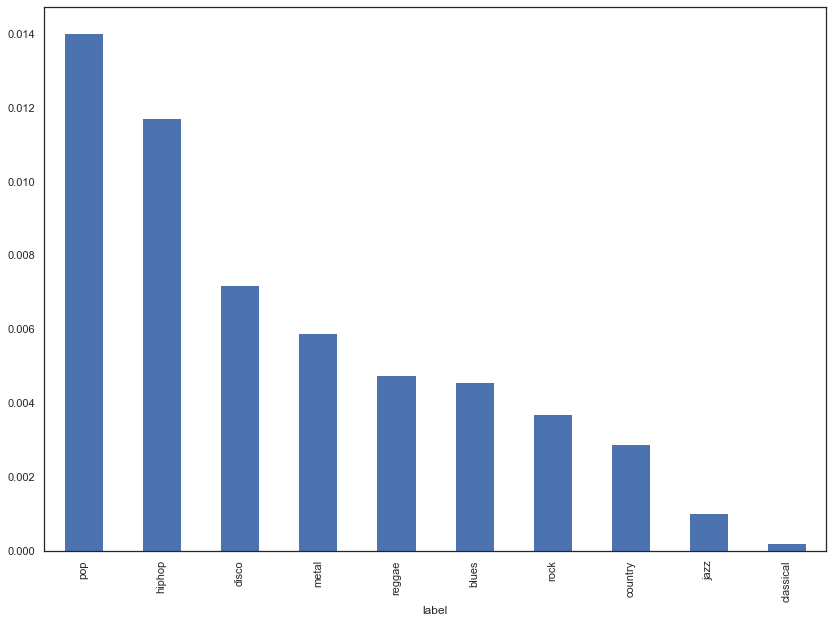

In [45]:
orig_df.groupby('label').mean()['perceptr_var'].sort_values(ascending=False).plot(kind='bar')